# **Pediatric Pneumonia Chest X-ray** 🫁

$\qquad$ <span style="color:gray"><b>0.</b> Settings </span><br>
$\qquad$ <span style="color:gray"><b>1.</b> Dataset </span><br>
$\qquad$ <span style="color:gray"><b>2.</b> Classes analysis </span><br>
$\qquad$ <span style="color:gray"><b>3.</b> Augmentation for data balancing </span><br>
$\qquad$ <span style="color:gray"><b>4.</b> Train and validation sets </span><br>
$\qquad$ <span style="color:gray"><b>5.</b> Model definition </span><br>
$\qquad$ <span style="color:gray"><b>6.</b> Training </span><br>
$\qquad\qquad$ <span style="color:gray"><b>6.1.</b> Compile the model </span><br>
$\qquad\qquad$ <span style="color:gray"><b>6.2.</b> Helper functions </span><br>
$\qquad\qquad\qquad$ <span style="color:gray"><b>6.2.1.</b> Accuracy </span><br>
$\qquad\qquad\qquad$ <span style="color:gray"><b>6.2.2.</b> Training step </span><br>
$\qquad\qquad\qquad$ <span style="color:gray"><b>6.2.3.</b> Evaluation step </span><br>
$\qquad\qquad$ <span style="color:gray"><b>6.3.</b> Training </span><br>
$\qquad$ <span style="color:gray"><b>7.</b> Prediction on test </span><br>
$\qquad\qquad$ <span style="color:gray"><b>7.1.</b> Accuracy on test </span><br>
$\qquad\qquad$ <span style="color:gray"><b>7.2.</b> Visualization of the results </span><br>
$\qquad\qquad$ <span style="color:gray"><b>7.3.</b> Confusion matrix </span><br>

## **0.** Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import os

# PyTorch
import torch

# PyTorch - Neural Networks
import torch.nn as nn
from torch import nn

# PyTorch - Gradient Descent Optimizers
from torch import optim

# PyTorch - Others
from torchvision import datasets, transforms, models
from torch.utils.data import ConcatDataset
import torchvision.transforms as transform
import torchvision.models as models
import torch.nn.functional as F

# Warnings off
import warnings
warnings.filterwarnings("ignore")

# Fix a seed for PyTorch
torch.manual_seed(42);

In [ ]:
## ===========================
##   GPU
## ===========================

gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

🟥 **What is the purpose of `element.to(device)`?**

Suppose we have GPU (`device = torch.device('cuda')`) and suppose we create a tensor `tensor_1`. <br>
We want to move the tensor to GPU so that it works faster.<br>
The following snippet moves the tensor to GPU:

```
    tensor_1.to(device)
```
Alternatively, it is possible to create a copy of `tensor_1` and move it to GPU, while keeping the original `tensor_1` in CPU.:

```
    tensor_2 = tensor_1.to(device)
```
In this case `tensor_1` and `tensor_2` are different.

## **1.** Dataset

In [ ]:
# Unzip the dataset
!unzip '/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/pediatric_pneumonia.zip'

In [ ]:
!ls /content

drive  sample_data  test  train


## **2.** Classes analysis

Before importing anything, let's find out if the classes are balanced.

Found 1349 elements for NORMAL
Found 3883 elements for PNEUMONIA


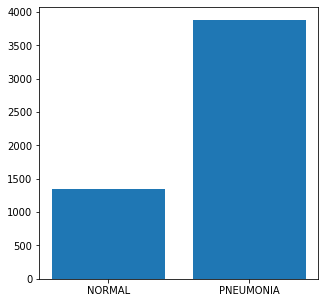

In [ ]:
# Set counters
n_samples_nr_train = len(os.listdir('train/NORMAL'))
n_samples_pn_train = len(os.listdir('train/PNEUMONIA'))

# Define two dictionaries
class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}
class_count = {0: n_samples_nr_train, 1: n_samples_pn_train}

# Print results
print(f'Found {class_count[0]} elements for {class_names[0]}')
print(f'Found {class_count[1]} elements for {class_names[1]}')

# Barplot
fig, ax = plt.subplots(figsize=(5,5));
ax.bar([class_names[0], class_names[1]], [class_count[0], class_count[1]]);

The classes are highly unbalanced, so it is necessary to balance them manually. In particular, in this notebook will be tested balancing via data augmentation. 

## **3.** Augmentation for data balancing

There are 3883 elements for `PNEUMONIA` and 1349 elements for `NORMAL`. <br>
For the classes to be (perfectly) balanced, it is possible to proceed in one of the following ways:
1. by removing some elements from the `PNEUMONIA` class (inconvenient, let`s not waste the data)
2. by generating 3883 - 1349 = 2534 images of `NORMAL` and adding them later to the training dataset.

For option 2. not to result in overfitting, the additional generated images must be different from the original ones.<br>
For this to be possible, an unique augmentation will be applied to each generated image.

What we have now is:
```
    original_ dataset = [NORMAL (1349), PNEUMONIA (3883)]
```

What we want to achieve is:
```
    original_dataset  = [NORMAL (1349), PNEUMONIA (3883)]
    dataset_augment_1 = [NORMAL (1349), PNEUMONIA (3883)]
    dataset_augment_2 = [NORMAL (1349), PNEUMONIA (3883)]
```

after which we will only consider:
```
    original_dataset  = [NORMAL (1349), PNEUMONIA (3883)]
    dataset_augment_1 = [NORMAL (1349),                 ]
    dataset_augment_2 = [NORMAL (1185),                 ]
```

so as to obtain:
```
    final_dataset = [NORMAL (3883), PNEUMONIA (3883)]
```

The augmentation transformations are available at https://pytorch.org/vision/stable/transforms.html.

In [ ]:
## ===========================
##   AUGMENTATION
## ===========================

training_transformations = {
    
    'original_data':  transforms.Compose([
                          transforms.Resize((256, 256)),
                          transforms.CenterCrop(224),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomRotation(10),
                          transforms.RandomGrayscale(),
                          transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                          transforms.ToTensor()]),

    'augmentation_1': transform.Compose([
                          transform.Resize((260, 260)),
                          transform.CenterCrop(224),
                          transform.RandomHorizontalFlip(p=1),
                          transform.RandomGrayscale(),
                          transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                          transform.ToTensor()]),
    
    'augmentation_2': transform.Compose([
                          transform.Resize((250, 250)),
                          transform.CenterCrop(224),
                          transform.RandomHorizontalFlip(p=0.5),
                          transform.RandomRotation(15),
                          transform.RandomGrayscale(p=1),
                          transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                          transform.ToTensor()])
}

## ===========================
##   DATA IMPORT - pt. 1
## ===========================

# Assosciate the dataset and the transformations with ImageFolder
original_data  = datasets.ImageFolder('train', transform = training_transformations['original_data'])
augmentation_1 = datasets.ImageFolder('train', transform = training_transformations['augmentation_1'])
augmentation_2 = datasets.ImageFolder('train', transform = training_transformations['augmentation_2'])

`ImageFolder` logs all the images in the `train` folder (both `NORMAL` and `PNEUMONIA`) in alphabetical order and in class order.<br>
Indeed, in this case, with the call `original_data.imgs` we get:

```
    [('train/NORMAL/AA.jpeg', 0),
     ('train/NORMAL/AB.jpeg', 0),
      ..
     ('train/NORMAL/ZZ.jpeg', 0),
     ('train/PNEUMONIA/AA.jpeg', 1),
     ('train/PNEUMONIA/AB.jpeg', 1),
      ..
     ('train/PNEUMONIA/ZZ.jpeg', 1)]
```

Taking advantage of this, we can use the `train_test_split()` function to extract the `NORMAL` class images from `augmentation_1` and `augmentation_2` as mentioned earlier. 

How does `train_test_split` work?

```
    train, test = train_test_split(data, test_size, shuffle)
```

The function assigns to `train` the first `(100-test_size*100)%` of the dataset `data` and to `test` the last `(test_size*100)%` of the dataset `data`. <br>
Since, in our case, `data` is in alphabetical and class order, it will be sufficient to compute the right percentage such that only `NORMAL` images will fall into `train`.

**`augmentation_1`**:<br>
From `augmentation_1` we want to take all 1349 images of `NORMAL`, consequently we have to attribute all others to `test`. This means:

```
    test_size = 3883 / (1349 + 3883)
```

**`augmentation_2`**:<br>
From `augmentation_2` we want to take only 1185 images of `NORMAL`. This means that we will leave 1349 - 1185 = images of `NORMAL` to `test`. Consequently:

```
    test_size = (3883 + 164) / (1349 + 3883)
```

In [ ]:
## ===========================
##   DATA IMPORT - pt. 2
## ===========================

# Extract images for 'NORMAL'
normal_aug_1, _ = train_test_split(augmentation_1, test_size= 3883/(1349+3883), shuffle=False)
normal_aug_2, _ = train_test_split(augmentation_1, test_size= (164+3883)/(1349+3883), shuffle=False)

# Create the ultimate dataset
dataset = ConcatDataset([original_data, normal_aug_1, normal_aug_2])

There are 3883 elements for NORMAL
There are 3883 elements for PNEUMONIA


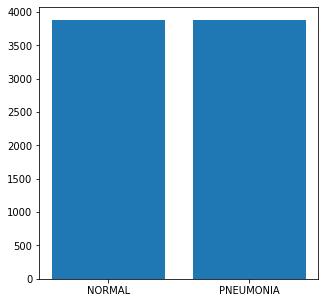

In [ ]:
## ===========================
##   BALANCE CHECK
## ===========================

# Considering the structure of 'dataset':
#   dataset.datasets[which, element, what]
#   which: {0: original_data, 1: normal_aug_1, 2: normal_aug_2}
#   what : {0: image, 1: label}

new_count_nr_train = 0
new_count_pn_train = 0

# Pass through 'original_data'
for i in range(len(dataset.datasets[0])):
    label = dataset.datasets[0][i][1]
    if label == 0:
        new_count_nr_train += 1
    elif label == 1:
        new_count_pn_train += 1

# Pass through 'normal_aug_1'
for i in range(len(dataset.datasets[1])):
    label = dataset.datasets[1][i][1]
    if label == 0:
        new_count_nr_train += 1
    elif label == 1:
        new_count_pn_train += 1

# Pass through 'normal_aug_2'
for i in range(len(dataset.datasets[2])):
    label = dataset.datasets[2][i][1]
    if label == 0:
        new_count_nr_train += 1
    elif label == 1:
        new_count_pn_train += 1

# Print informations
print(f'There are {new_count_nr_train} elements for {class_names[0]}')
print(f'There are {new_count_pn_train} elements for {class_names[1]}')

# Barplot
fig, ax = plt.subplots(figsize=(5,5));
ax.bar([class_names[0], class_names[1]], [new_count_nr_train, new_count_pn_train]);

## **4.** Train and validation sets

In [ ]:
# Split training data in train and validation
train_split, val_split = train_test_split(dataset, test_size=0.3)

# Print informations
print(f'{len(train_split)} images for training, {len(val_split)} images for validation')

5436 images for training, 2330 images for validation


In [ ]:
# Batch size
batch_size = 64

# Load the datasets with DataLoader
train_loader = torch.utils.data.DataLoader(train_split, batch_size = batch_size, shuffle = True)
val_loader   = torch.utils.data.DataLoader(val_split,   batch_size = batch_size, shuffle = True)

# Class-number association
class_index = {0: 'NORMAL', 1: 'PNEUMONIA'}

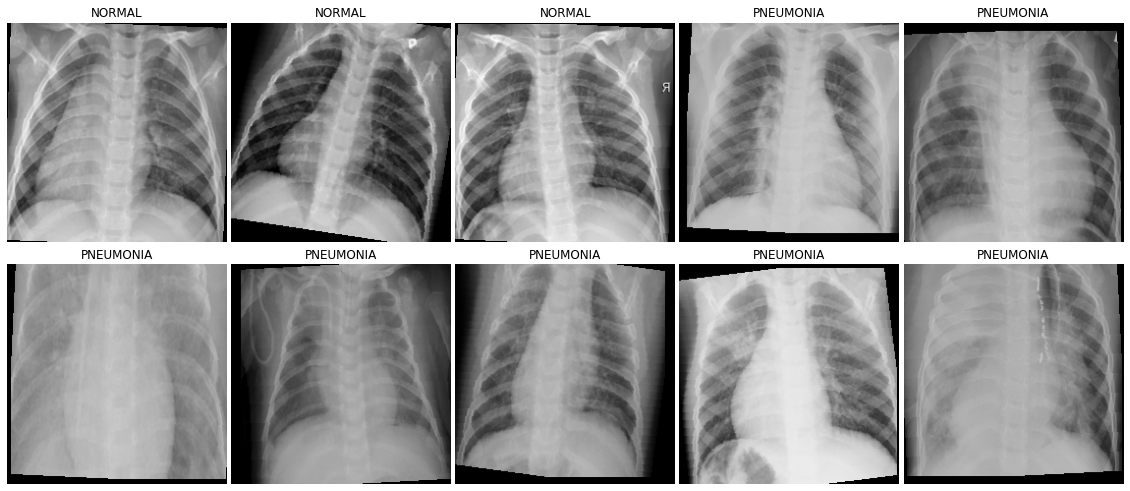

In [ ]:
## Visualize some images

plt.figure(figsize=(20, 10))
n_rows = 2
n_cols = 5

# Extract images from 'train_loader'
images, labels = next(iter(train_loader))

# Display images
for i in range(n_rows*n_cols):
  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
  plt.title(class_index[labels.numpy()[i]])
  plt.axis('off')

plt.subplots_adjust(wspace=.02, hspace=-.2)

## **5.** Model definition

It is possible to perform transfer learning loading a pre-trained model and weigts from https://pytorch.org/vision/stable/models.html.

In [ ]:
# Base model (transfer learning): DenseNet-161
# Transfer Learning
model = models.densenet161(pretrained=True)
model

The output (restricted) is:

```
    DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock( .. )
        (transition1): _Transition( .. ) 
        (denseblock2): _DenseBlock( .. )
        (transition2): _Transition( .. )
        (denseblock3): _DenseBlocl( .. ) 
        (transition3): _Transition( .. ) 
        (denseblock4): _DenseBlock( .. )
        (norm5): BatchNorm2d(2208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (classifier): Linear(in_features=2208, out_features=1000, bias=True)
    )
```



In [ ]:
# Important: compatibility problem
# Whatever classifier we put, it will have to have 'model.classifier.in_features' as 'in_features'
model.classifier.in_features

2208

We are importing everything: feature extractor and classifier. What we are interested in now is to replace the classifier with one adapted to our case.<br>
We notice that here the classifier is given by `classifier` and we also see that `in_features` has 2208 neurons.<br>
Therefore, whatever we put in the classifier place, it must have `in_features=2208`.<br>
We also notice (out of curiosity) that the number of classes in this case is `out_features=1000`.

In [ ]:
# Freeze the weights of the pre-trained model
for parameter in model.parameters():
    parameter.requires_grad = False

In [ ]:
# Build a custom classifier
initial_num_neurons = model.classifier.in_features
num_classes = len(class_index)

# New classifier
classifier = nn.Linear(in_features=initial_num_neurons, out_features=num_classes)

# Replace the transfer learning model classifier
model.classifier = classifier

## **6.** Training

### **6.1.** Compile the model

In [ ]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer and learning rate
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Adapter
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

We pass `model.classifier.parameters()` rather than `model.parameters()` to the optimizer because we want to keep the feature selector parameters frozen.

### **6.2.** Helper functions

#### **6.2.1.** Accuracy

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)                   # extract the prediction
    num_correct    = torch.sum(predictions == labels).item()     # count how many correct predictions (.item() to obtain a python-number)
    perc_correct   = torch.tensor(num_correct/len(predictions))  

    return perc_correct

Here, as `outputs` we'll have a tensor of the form:

```
    tensor([[value_class_0, value_class_1],   # elem 1 of the batch
            [value_class_0, value_class_1],   # elem 2 of the batch
              ..
            [value_class_0, value_class_1],   # elem 64 of the batch
    ])
```

Where, if we pass `[value_class_0, value_class_1]` of `elem 1` to the softmax function we get `[prob_class_0, prob_class_1]` for `elem 1`.

Suppose that for the first element it holds `val_class_0` > `val_class_1` and for all the others vice versa.<br>
With the call:

```
    values, preds = torch.max(outputs, dim=1)
```

we get a result such as:

```
    values = tensor([value_class_0, value_class_1, value_class_1, .., value_class_1])
    preds  = tensor([0, 1, 1, .., 1])
```

and we are only interested in `preds`.

#### **6.2.2.** Training step

In [ ]:
def training_step(model, loader, loss_function):
    
    # Training-mode
    model.train()

    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0

    #---------------------------------------------------------- Batch-loop ---------#
    for images, labels in iter(loader):                                             #
                                                                                    #
        # Load images and labels to 'device'                                        #
        images, labels = images.to(device), labels.to(device)                       #
                                                                                    #
        # Initialize the gradient                                                   #
        optimizer.zero_grad()                                                       #
                                                                                    #
        #-------------------------------------------------------- Training ----#    #
        with torch.set_grad_enabled(True):                                     #    #
                                                                               #    #
            # Output from the model (from the forward pass)                    #    #
            output = model(images)                                             #    #
                                                                               #    #
            # Calculate the loss_function for the current batch                #    #
            loss = loss_function(output, labels)                               #    #
                                                                               #    #
            # Perform the backpropagation (backpropagate the error)            #    #
            loss.backward()                                                    #    #
                                                                               #    #
            # Gradient descent step to update parameters (weights/biases)      #    #
            optimizer.step()                                                   #    #
                                                                               #    #
            # Extract predictions                                              #    #
            _, predictions = torch.max(output, dim=1)                          #    #
        #----------------------------------------------------------------------#    #
                                                                                    #
        # Update loss (+= loss * num_images_in_the_batch)                           #
        # (.item(): returns the value of the tensor as a standard number)           #
        epoch_loss += loss.item()*images.size(0)                                    #
                                                                                    #
        # Update correct                                                            #
        epoch_correct += torch.sum(predictions == labels)                           #
    #-------------------------------------------------------------------------------#

    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

🗝️ **Key steps: `optimizer.zero_grad()`, `loss.backward()`, `optimizer.step()`.**

For every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropragation.<br>
This is the reason for `optimizer.zero_grad()`.

With the call `loss.backward()`, all it does is to compute the gradient of the loss function with respect to all the parameters in the loss function that have `requires_grad = True` and store the computed values in `parameter.grad` attribute for every parameter.

Instead, `optimizer.step()` updates all the parameters based on `parameter.grad` of each.<br>
It doesn't need to know with respect to what loss the gradients were computed, it just wants to access `parameter.grad` so it can do: `param = param - lr * param.grad`.

#### **6.2.3.** Evaluation step

In [ ]:
def evaluate_model(model, loader, loss_function):

    # Evaluation-mode
    model.eval()

    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0

    #---------------------------------------------------------- Batch-loop ---------#
    for images, labels in iter(loader):                                             #
                                                                                    #
        # Load images and labels to 'device'                                        #
        images, labels = images.to(device), labels.to(device)                       #
                                                                                    #
        #------------------------------------------------------ Evaluation ----#    #
        with torch.set_grad_enabled(False):                                    #    #
                                                                               #    #
            # Output from the model (from the forward pass)                    #    #
            output = model(images)                                             #    #
                                                                               #    #
            # Calculate the loss_function for the current batch                #    #
            loss = loss_function(output, labels)                               #    #
                                                                               #    #
            # Extract predictions                                              #    #
            _, predictions = torch.max(output, dim=1)                          #    #
        #----------------------------------------------------------------------#    #
                                                                                    #
        # Update loss (+= loss * num_images_in_the_batch)                           #
        # (.item(): returns the value of the tensor as a standard number)           #
        epoch_loss += loss.item()*images.size(0)                                    #
                                                                                    #
        # Update correct                                                            #
        epoch_correct += torch.sum(predictions == labels)                           #
    #-------------------------------------------------------------------------------#

    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

### **6.3.** Training

In [ ]:
# Number of epochs
epochs = 15

# Monitor 'val_loss'
best_val_loss = float('inf')

# Model to device
model.to(device)

# For the records
train_loss_savings = []
train_acc_savings  = []
val_loss_savings   = []
val_acc_savings    = []

# Saving the model
best_model = copy.deepcopy(model.state_dict())

# ======================================
#   TRAINING
# ======================================

for epoch in range(epochs):

    # Training step
    train_loss, train_acc = training_step(model, train_loader, loss_function) 
    train_loss_savings.append(train_loss)
    train_acc_savings.append(train_acc.item())

    # Evaluation step
    val_loss, val_acc = evaluate_model(model, val_loader, loss_function)
    val_loss_savings.append(val_loss)
    val_acc_savings.append(val_acc.item())

    # Print results
    print(f'Epoch: {epoch+1:02}/{epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

    # If the val_loss improved, save the model
    if val_loss < best_val_loss:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss improved from {best_val_loss:.4f} to {val_loss:.4f}, new model saved')
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())                                             
    else:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss did not improve')

    # Update scheduler (learning rate adapter)
    scheduler.step()

Epoch: 01/15 - train_loss: 0.2663 - train_accuracy: 0.9257 - val_loss: 0.1781 - val_accuracy: 0.9455
Epoch: 01/15 - val_loss improved from inf to 0.1781, new model saved
Epoch: 02/15 - train_loss: 0.1750 - train_accuracy: 0.9422 - val_loss: 0.1358 - val_accuracy: 0.9584
Epoch: 02/15 - val_loss improved from 0.1781 to 0.1358, new model saved
Epoch: 03/15 - train_loss: 0.1379 - train_accuracy: 0.9582 - val_loss: 0.1206 - val_accuracy: 0.9597
Epoch: 03/15 - val_loss improved from 0.1358 to 0.1206, new model saved
Epoch: 04/15 - train_loss: 0.1288 - train_accuracy: 0.9579 - val_loss: 0.1103 - val_accuracy: 0.9639
Epoch: 04/15 - val_loss improved from 0.1206 to 0.1103, new model saved
Epoch: 05/15 - train_loss: 0.1150 - train_accuracy: 0.9616 - val_loss: 0.1092 - val_accuracy: 0.9648
Epoch: 05/15 - val_loss improved from 0.1103 to 0.1092, new model saved
Epoch: 06/15 - train_loss: 0.1132 - train_accuracy: 0.9636 - val_loss: 0.1092 - val_accuracy: 0.9657
Epoch: 06/15 - val_loss did not impro

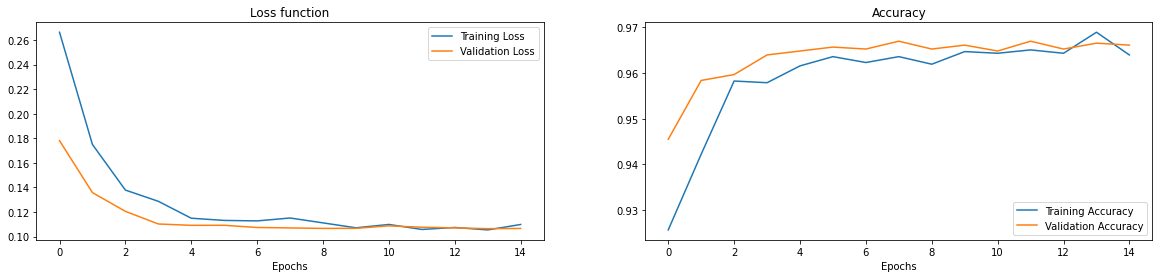

In [ ]:
# ======================================
#   TRENDS
# ======================================

plt.figure(figsize=(20,4));

# Loss function
plt.subplot(1,2,1)
plt.plot(train_loss_savings, label='Training Loss');
plt.plot(val_loss_savings, label='Validation Loss');
plt.title('Loss function');
plt.xlabel('Epochs');
plt.legend();

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc_savings, label='Training Accuracy');
plt.plot(val_acc_savings, label='Validation Accuracy');
plt.title('Accuracy');
plt.xlabel('Epochs');
plt.legend();

In [ ]:
# ======================================
#   SAVE THE MODEL
# ======================================

# Path for saving the best model
path_best_model = '/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/'

# Save the model
torch.save(model.state_dict(), path_best_model + 'best-model-augmentation.pt')

Sometimes it is convenient to retrain the whole network after the last layers have been trained. In most cases this leads to an increase in performance.<br>
Note that, in practice, if the dataset is particularly small this can lead to a worsening of the performance.

🟥 Especially working online, there is often a risk of ending up in OOM.

In [ ]:
# # ======================================
# #   RE-DEFINE THE OPTIMIZER
# # ======================================
#
# # Unfreeze all the parameters
# for param in model.parameters():
#     param.requires_grad = False
#   
# # Re-define the optimizer (with a learning rate can be reduced by 10 times)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#
# # Adapter
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
#
# # ======================================
# #   RE-DEFINE TRAINING OPTIONS
# # ======================================
#
# # Number of epochs
# epochs = 15
#
# # Model to device
# model.to(device)
#
# # Saving the model
# best_model = copy.deepcopy(model.state_dict())
#
# # ======================================
# #   TRAINING
# # ======================================
#
# for epoch in range(epochs):
#
#     # Training step
#     train_loss, train_acc = training_step(model, train_loader, loss_function) 
#     train_loss_savings.append(train_loss)
#     train_acc_savings.append(train_acc.item())
#
#     # Evaluation step
#     val_loss, val_acc = evaluate_model(model, val_loader, loss_function)
#     val_loss_savings.append(val_loss)
#     val_acc_savings.append(val_acc.item())
#
#     # Print results
#     print(f'Epoch: {epoch+1:02}/{epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')
#
#     if val_loss < best_val_loss:
#         print(f'Epoch: {epoch+1:02}/{epochs} - val_loss improved from {best_val_loss:.4f} to {val_loss:.4f}, new model saved')
#         best_val_loss = val_loss
#         best_model = copy.deepcopy(model.state_dict())                                             
#     else:
#         print(f'Epoch: {epoch+1:02}/{epochs} - val_loss did not improve')
#
#     # Update scheduler (learning rate adapter)
#     scheduler.step()
#
# # ======================================
# #   TRENDS
# # ======================================
#
# plt.figure(figsize=(20,4));
#
# # Loss function
# plt.subplot(1,2,1)
# plt.plot(train_loss_savings, label='Training Loss');
# plt.plot(val_loss_savings, label='Validation Loss');
# plt.title('Loss function');
# plt.xlabel('Epochs');
# plt.legend();
#
# # Accuracy
# plt.subplot(1,2,2)
# plt.plot(train_acc_savings, label='Training Accuracy');
# plt.plot(val_acc_savings, label='Validation Accuracy');
# plt.title('Accuracy');
# plt.xlabel('Epochs');
# plt.legend();
#
# # ======================================
# #   SAVE THE MODEL
# # ======================================
#
# # Path for saving the best model
# path_best_model = '/content/drive/MyDrive/Pediatric Chest X-ray Pneumonia/'
#
# # Save the model
# torch.save(model.state_dict(), path_best_model + 'best-model-augmentation.pt')

## **7.** Prediction on test

### **7.1.** Accuracy on test

In [ ]:
# Load the best version of the model
model.load_state_dict(torch.load(path_best_model + 'best-model-augmentation.pt'))

<All keys matched successfully>

In [ ]:
# Import the test data
test_transform = transforms.Compose([
                     transforms.Resize((256, 256)),
                     transforms.CenterCrop(224),
                     transforms.ToTensor()])

test_data = datasets.ImageFolder('test', transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [ ]:
def get_probs_and_preds(model, loader):

    model.eval()

    images_savings = []
    labels_savings = []
    probs_savings  = []
    preds_savings  = []

    #---------------------------------------------------------- Batch-loop ---------#
    for images, labels in iter(loader):                                             #
        images, labels = images.to(device), labels.to(device)                       #
        #------------------------------------------------------ Evaluation ----#    #
        with torch.set_grad_enabled(False):                                    #    #
            output = model(images)                                             #    #
            output = F.softmax(output)                                         #    #
            probabilities, predictions = torch.max(output, dim=1)              #    #
        #----------------------------------------------------------------------#    #
        images_savings.append(images.cpu())                                         #
        labels_savings += labels.tolist()                                           #
        probs_savings  += probabilities.tolist()                                    #
        preds_savings  += predictions.tolist()                                      #
    #-------------------------------------------------------------------------------#

    # Accuracy
    correct_elements = 0
    for i in range(len(labels_savings)):
        if labels_savings[i] == preds_savings[i]:
            correct_elements += 1
    accuracy = correct_elements/len(labels_savings)

    return images_savings, labels_savings, probs_savings, preds_savings, accuracy

In [ ]:
# Evaluate the model on test data
images, labels, probs, preds, accuracy = get_probs_and_preds(model, test_loader)

# Print results
print(f'Accuracy on test: {accuracy:.4f}')

Accuracy on test: 0.8942


### **7.2.** Visualization of the results

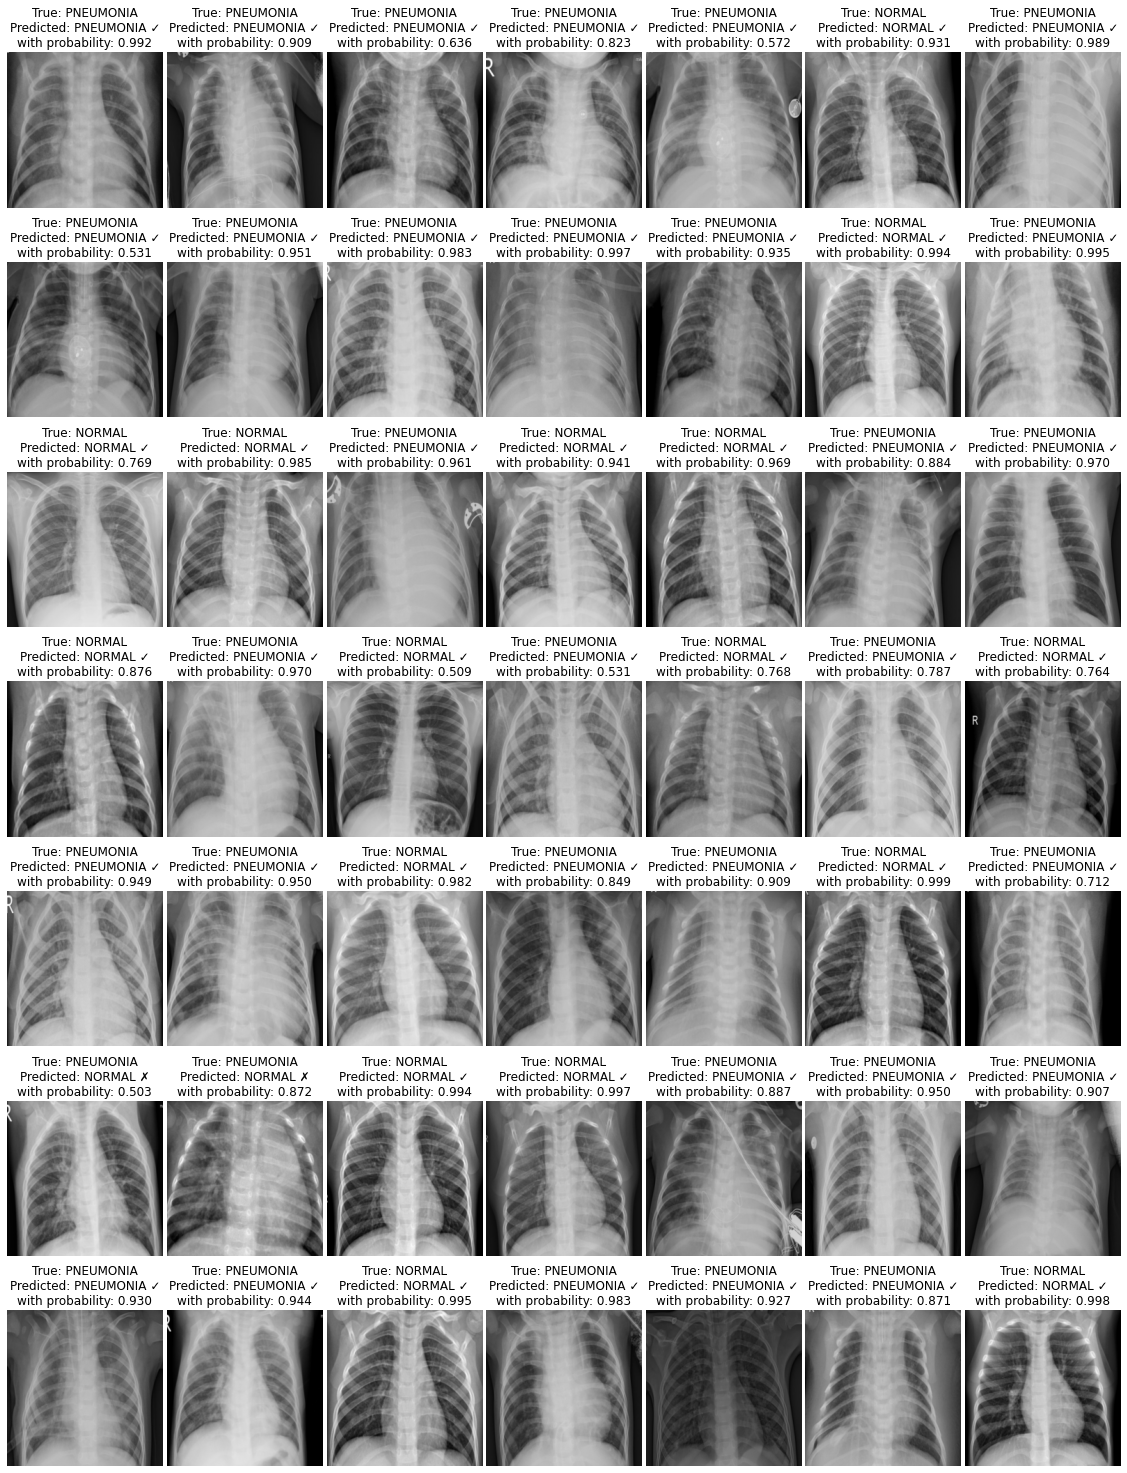

In [ ]:
## Visualize some images with: true label, predicted label, probability

plt.figure(figsize=(20, 26))
n_rows = 7
n_cols = 7

# Display images
for i in range(n_rows*n_cols):
  text_true = 'True: ' + class_index[labels[i]]
  text_pred = '\nPredicted: ' + class_index[preds[i]]
  text_prob = '\nwith probability: ' + str(probs[i])[:5]

  if labels[i] == preds[i]:
      text_correct = ' ✓'
  else:
      text_correct = ' ✗'

  # Plot the image
  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(np.transpose(images[0][i].numpy(), (1, 2, 0)))
  plt.title(text_true + text_pred + text_correct + text_prob)
  plt.axis('off')

plt.subplots_adjust(wspace=.01, hspace=.35)

### **7.3.** Confusion matrix

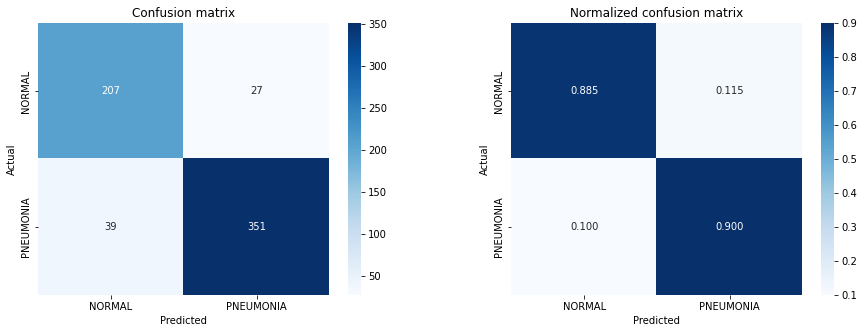

In [ ]:
# Build the confusion matrix
cm = confusion_matrix(labels, preds)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Ticklables
ticklabels = class_index.values()

# Plot
fig, ax = plt.subplots(figsize=(15,5))

# Confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Normalized confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

plt.subplots_adjust(wspace=.3)